<a href="https://colab.research.google.com/github/pankaj90382/TSAI/blob/master/S5/EVA4_Session_5_Approach3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(8)) 
        self.convblock2 = nn.Sequential(nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(16))
        self.convblock3 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.convblock4 = nn.Sequential(nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(16))
        self.convblock5 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(32))
        self.convblock6 = nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)
        self.convblock7 = nn.Sequential(nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(16))
        self.convblock8 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),nn.ReLU(),nn.BatchNorm2d(16))
        self.gap = nn.Sequential(nn.AvgPool2d(kernel_size=7)) # output_size = 1
        self.convblock9 = nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        #self.conv6 = nn.Conv2d(32, 32, 3)
        #self.conv7 = nn.Conv2d(32, 10, 3)

    def forward(self, x):
        x = self.convblock1(x) #input - 28; Output - 28; RF - 3; output channels - 8
        x = self.convblock2(x) #input - 28; Output - 28; RF - 5; output channels - 16
        x = self.convblock3(x) #input - 28; Output - 28; RF - 5; output channels - 8
        x = self.pool1(x) #input - 28; Output - 14; RF - 6; output channels - 8
        x = self.convblock4(x)#input - 14; Output - 14; RF - 10; output channels - 16
        x = self.convblock5(x)#input - 14; Output - 14; RF - 14; output channels - 32
        x = self.convblock6(x)#input - 14; Output - 14; RF - 14; output channels - 8
        x = self.pool1(x) #input - 14; Output - 7; RF - 16; output channels - 8
        x = self.convblock7(x) #input - 7; Output - 7; RF - 24; output channels - 16
        x = self.convblock8(x)  #input - 7; Output - 7; RF - 32; output channels - 16
        x = self.gap(x)        
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [3]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
            Conv2d-4           [-1, 16, 28, 28]           1,152
              ReLU-5           [-1, 16, 28, 28]               0
       BatchNorm2d-6           [-1, 16, 28, 28]              32
            Conv2d-7            [-1, 8, 28, 28]             128
         MaxPool2d-8            [-1, 8, 14, 14]               0
            Conv2d-9           [-1, 16, 14, 14]           1,152
             ReLU-10           [-1, 16, 14, 14]               0
      BatchNorm2d-11           [-1, 16, 14, 14]              32
           Conv2d-12           [-1, 32, 14, 14]           4,608
             ReLU-13           [-1, 32, 14, 14]               0
      BatchNorm2d-14           [-1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)
        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.
        
        # Predict
        y_pred = model(data)
        
        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Update pbar-tqdm
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [6]:
from torch.optim.lr_scheduler import StepLR

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
loss=0.13576941192150116 batch_id=468 Accuracy=87.05: 100%|██████████| 469/469 [00:11<00:00, 41.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1406, Accuracy: 9622/10000 (96.22%)

EPOCH: 1


loss=0.05497461557388306 batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:10<00:00, 43.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0720, Accuracy: 9788/10000 (97.88%)

EPOCH: 2


loss=0.08150000870227814 batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:10<00:00, 44.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0844, Accuracy: 9730/10000 (97.30%)

EPOCH: 3


loss=0.030248478055000305 batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:10<00:00, 43.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0552, Accuracy: 9833/10000 (98.33%)

EPOCH: 4


loss=0.020236177369952202 batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:10<00:00, 43.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9865/10000 (98.65%)

EPOCH: 5


loss=0.059825148433446884 batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:11<00:00, 41.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9870/10000 (98.70%)

EPOCH: 6


loss=0.09256169945001602 batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:10<00:00, 44.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0353, Accuracy: 9881/10000 (98.81%)

EPOCH: 7


loss=0.0553632415831089 batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:10<00:00, 45.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9889/10000 (98.89%)

EPOCH: 8


loss=0.007408127188682556 batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:10<00:00, 43.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9891/10000 (98.91%)

EPOCH: 9


loss=0.05926065519452095 batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:12<00:00, 39.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0464, Accuracy: 9855/10000 (98.55%)

EPOCH: 10


loss=0.030731672421097755 batch_id=468 Accuracy=99.40: 100%|██████████| 469/469 [00:11<00:00, 41.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0368, Accuracy: 9886/10000 (98.86%)

EPOCH: 11


loss=0.026485485956072807 batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:11<00:00, 41.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9890/10000 (98.90%)

EPOCH: 12


loss=0.020325208082795143 batch_id=468 Accuracy=99.49: 100%|██████████| 469/469 [00:11<00:00, 39.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 9881/10000 (98.81%)

EPOCH: 13


loss=0.02066478133201599 batch_id=468 Accuracy=99.51: 100%|██████████| 469/469 [00:11<00:00, 41.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0487, Accuracy: 9843/10000 (98.43%)

EPOCH: 14


loss=0.0024452905636280775 batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:11<00:00, 41.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9882/10000 (98.82%)

EPOCH: 15


loss=0.004321366548538208 batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:10<00:00, 43.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9876/10000 (98.76%)

EPOCH: 16


loss=0.017251109704375267 batch_id=468 Accuracy=99.65: 100%|██████████| 469/469 [00:10<00:00, 43.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9893/10000 (98.93%)

EPOCH: 17


loss=0.0012481510639190674 batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:11<00:00, 42.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9880/10000 (98.80%)

EPOCH: 18


loss=0.011796519160270691 batch_id=468 Accuracy=99.64: 100%|██████████| 469/469 [00:10<00:00, 43.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9901/10000 (99.01%)

EPOCH: 19


loss=0.012732689268887043 batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:11<00:00, 40.75it/s]



Test set: Average loss: 0.0284, Accuracy: 9914/10000 (99.14%)



# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

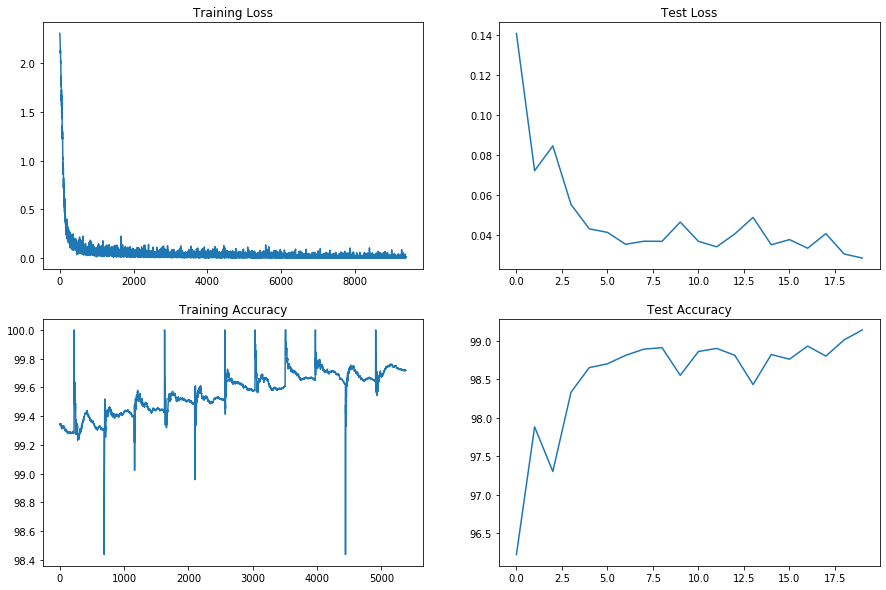

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")